### Example 1 - Map of chlorophyll content in the North West Atlantic

This example will show you how to read and manipulate Argo profiles data stored in parquet format in your machine.

The data are stored across multiple files: we will load into memory only what we need by applying some filters, and we will create a map showing the chlorophyll content in the North West Atlantic.

##### Note on performance

I have developed this example on WHOI's HPC cluster. If you have access to an HPC machine, I recommend using it. If not, filter more aggressively or skip the parts where a lot of data is loaded (the first example loads ~45 GB).

As I am accessing data in a cluster, reading times are of course influenced by my internet connection, besides the file format.

##### Note on parquet files

The original netCDF Argo files have been converted to parquet format, which provides faster read operations.

There are a couple of ways to read parquet files in Python. We will use pyarrow to load the dataset, so that we can provide a target schema (containing the Argo variable names) and load the data consistently across floats, independently of what variables each float actually has. We will finally convert the dataset to a pandas dataframe for manipulation and plots.
Other ways to read parquet files are by using pandas (make sure you have pyarrow, fastparquet or some other suitable engine installed), and Dask. Generally speaking, you'll want to use Dask only if you need a large amount of data at the same time so that you can benefit from its parallelization. You should avoid Dask whenever the data fits in your RAM.

When reading parquet files with pyarrow (or pandas), you can either specificy the file name(s), or the directory containing all the parquet files. In the latter case if you apply any filter, pandas and pyarrow will sort through all the files in the folder, reading into memory only the subsets that satisfy your filter.

#### Getting started

We start by importing the necessary modules and setting the path and filenames of the parquet files.  For a list of modules that you need to install, you can look at the [README.md file in the repository](https://github.com/boom-lab/nc2parquet).

We also set up the unified schema that pyarrow will need to read the parquet files. This is needed because not all parquet files contain the same variables, depending on what variables are contained in the Argo floats inside each file. This reduces the number of empty fields, and in turn the memory usage during the conversion of the Argo mirror to the parquet format. If we didn't provide the unified schema, pyarrow would not read all the data.

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import pyarrow as pa
import pyarrow.parquet as pq
from pprint import pprint

# Paths on Poseidon cluster
parquet_dir = '/vortexfs1/share/boom/data/nc2pqt_test/pqt/data/'

# Setting up parquet schema
schema_path = '../schemas/ArgoBGC_schema.metadata'
BGC_schema = pq.read_schema(schema_path)

# We import argopy only for speed comparisons
import argopy
argopy.reset_options()
argopy.set_options(dataset='bgc')

We now want to set up our filter to read only the data from the NWA (i.e. latitude between 34$^\circ$ and 60$^\circ$, longitude between -45$^\circ$ and -78$^\circ$).

We first query the parquet files for the variable names, as we might not be familiar with them, or we might want to make sure that indeed the names have not been changed from the Argo convention.

In [2]:
dataset = pq.ParquetDataset(parquet_dir, schema=BGC_schema)
schema = dataset.schema
pprint(sorted(schema.names))

['BBP470',
 'BBP470_ADJUSTED',
 'BBP470_ADJUSTED_ERROR',
 'BBP470_ADJUSTED_QC',
 'BBP470_QC',
 'BBP470_dPRES',
 'BBP532',
 'BBP532_ADJUSTED',
 'BBP532_ADJUSTED_ERROR',
 'BBP532_ADJUSTED_QC',
 'BBP532_QC',
 'BBP532_dPRES',
 'BBP700',
 'BBP700_ADJUSTED',
 'BBP700_ADJUSTED_ERROR',
 'BBP700_ADJUSTED_QC',
 'BBP700_QC',
 'BBP700_dPRES',
 'BISULFIDE',
 'BISULFIDE_ADJUSTED',
 'BISULFIDE_ADJUSTED_ERROR',
 'BISULFIDE_ADJUSTED_QC',
 'BISULFIDE_QC',
 'BISULFIDE_dPRES',
 'CDOM',
 'CDOM_ADJUSTED',
 'CDOM_ADJUSTED_ERROR',
 'CDOM_ADJUSTED_QC',
 'CDOM_QC',
 'CDOM_dPRES',
 'CHLA',
 'CHLA_ADJUSTED',
 'CHLA_ADJUSTED_ERROR',
 'CHLA_ADJUSTED_QC',
 'CHLA_QC',
 'CHLA_dPRES',
 'CP660',
 'CP660_ADJUSTED',
 'CP660_ADJUSTED_ERROR',
 'CP660_ADJUSTED_QC',
 'CP660_QC',
 'CP660_dPRES',
 'CYCLE_NUMBER',
 'DOWNWELLING_PAR',
 'DOWNWELLING_PAR_ADJUSTED',
 'DOWNWELLING_PAR_ADJUSTED_ERROR',
 'DOWNWELLING_PAR_ADJUSTED_QC',
 'DOWNWELLING_PAR_QC',
 'DOWNWELLING_PAR_dPRES',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE380_ADJUSTED'

The geographical coordinates are stored in the variables 'LATITUDE'and 'LONGITUDE'. We then generate the filter, with its syntax being: `[[(column, op, val), …],…]` where `column` is the variable name, and `val` is the value to for the operator `op`, which accepts `[==, =, >, >=, <, <=, !=, in, not in]`,

In [3]:
filter_coords = [("LATITUDE",">",34), ("LATITUDE","<",80),
                 ("LONGITUDE",">",-78), ("LONGITUDE","<",-50)]

To get a pandas dataframe, we need first to create a parquet dataset that pyarrow can read with `ParquetDataset()`, then we read it into a pandas dataframe with `read().to_pandas()` methods of the dataset. The filters are applied when `ParquetDataset()` is called.

**NB:** The following operation still fetches a large amount of data (~46 GB), so you can skip executing it if your machine does not have enough memory and/or your internet connection isn't great.

In [4]:
%%time
ds = pq.ParquetDataset(parquet_dir, schema=BGC_schema, filters=filter_coords)
df = ds.read().to_pandas()
df

CPU times: user 6min 27s, sys: 4min 13s, total: 10min 40s
Wall time: 1min 3s


PRES_ADJUSTED_QC  TEMP_ADJUSTED_QC  DOXY  PLATFORM_NUMBER  \
N_PROF N_LEVELS                                                              
0.0    0.0                    0.0               0.0   NaN        4902508.0   
       1.0                    0.0               0.0   NaN        4902508.0   
       2.0                    0.0               0.0   NaN        4902508.0   
       3.0                    0.0               0.0   NaN        4902508.0   
       4.0                    0.0               0.0   NaN        4902508.0   
...                           ...               ...   ...              ...   
386.0  1015.0                 0.0               0.0   NaN        4903237.0   
       1016.0                 0.0               0.0   NaN        4903237.0   
       1017.0                 0.0               0.0   NaN        4903237.0   
       1018.0                 0.0               0.0   NaN        4903237.0   
       1019.0                 0.0               0.0   NaN        4903237.0   

                 PSAL_dPRES  DOXY_ADJUSTED_ERROR   TEMP   LATITUDE  \
N_PROF N_LEVELS                                                      
0.0    0.0              0.0                  NaN  3.793  56.702042   
       1.0              0.0                  NaN  3.799  56.702042   
       2.0              0.0                  NaN  3.801  56.702042   
       3.0              0.0                  NaN  3.801  56.702042   
       4.0              0.0                  NaN  3.801  56.702042   
...                     ...                  ...    ...        ...   
386.0  1015.0           NaN                  NaN    NaN  36.018180   
       1016.0           NaN                  NaN    NaN  36.018180   
       1017.0           NaN                  NaN    NaN  36.018180   
       1018.0           NaN                  NaN    NaN  36.018180   
       1019.0           NaN                  NaN    NaN  36.018180   

                 TEMP_dPRES  PSAL_ADJUSTED_ERROR  ...  BISULFIDE_ADJUSTED_QC  \
N_PROF N_LEVELS                                   ...                          
0.0    0.0              0.0                  NaN  ...                    NaN   
       1.0              0.0                  NaN  ...                    NaN   
       2.0              0.0                  NaN  ...                    NaN   
       3.0              0.0                  NaN  ...                    NaN   
       4.0              0.0                  NaN  ...                    NaN   
...                     ...                  ...  ...                    ...   
386.0  1015.0           NaN                  NaN  ...                    NaN   
       1016.0           NaN                  NaN  ...                    NaN   
       1017.0           NaN                  NaN  ...                    NaN   
       1018.0           NaN                  NaN  ...                    NaN   
       1019.0           NaN                  NaN  ...                    NaN   

                 BISULFIDE_ADJUSTED_ERROR  BISULFIDE_QC  BISULFIDE  \
N_PROF N_LEVELS                                                      
0.0    0.0                            NaN           NaN        NaN   
       1.0                            NaN           NaN        NaN   
       2.0                            NaN           NaN        NaN   
       3.0                            NaN           NaN        NaN   
       4.0                            NaN           NaN        NaN   
...                                   ...           ...        ...   
386.0  1015.0                         NaN           NaN        NaN   
       1016.0                         NaN           NaN        NaN   
       1017.0                         NaN           NaN        NaN   
       1018.0                         NaN           NaN        NaN   
       1019.0                         NaN           NaN        NaN   

                 TURBIDITY_dPRES  TURBIDITY_ADJUSTED  TURBIDITY  \
N_PROF N_LEVELS                                                   
0.0  

You can explore the dataframe just by calling it (`df`) as we did above. If you want a list of the variables that are stored, you can use `sorted(df.columns.to_list())`.

#### Timing test

The function above took a bit less than a minute on my machine. Let's verify how much data has been loaded:

In [5]:
print( str( df.memory_usage().sum()*1e-9 ) + " GB.")

46.367735496 GB.


We now want to compare this timing with Argopy's functionalities. Its data fetcher requires to specificy the depth range, which we then set to between 0 and 10000, i.e. all depths present in the dataset.

NB: the execution should throw an exception after 1 minute (if it doesn't, let me know!). This is likely due to ERDAP's servers timing out after that time (as the wall time consistently measures).

In [6]:
%%time
f = argopy.DataFetcher()
f = f.region([-78, -50, 34, 80, 0, 10000])
try:
    f.load()
except Exception as e:
    print(f"Exception: {e}")

/vortexfs1/home/enrico.milanese/projects/ARGO/nc2parquet/venv/venv3.9/lib/python3.9/site-packages/argopy/fetchers.py:168: UserWarning: The 'bgc' dataset fetching is only available in 'expert' mode at this point.
  warnings.warn(


Exception: 
CPU times: user 1.42 s, sys: 177 ms, total: 1.6 s
Wall time: 1min 8s


We just saw that if we need a large amount of data, our parquet-based mirror of Argo's data is faster.

Now let's narrow the filters in time and depth -- let's say we we want to select the data recorded between July 2023 and October 2023, and measured between 0 and 50 db. The resulting pandas dataframe will now be much smaller (~60 kB).

In [14]:
from datetime import datetime, timedelta
t0 = datetime(2023, 7, 1)
t1 = datetime(2023, 10, 31)
# reference_time = datetime.utcnow() - timedelta(days=90)
filter_coords_time_pres = [("LATITUDE",">",34), ("LATITUDE","<",80),
                           ("LONGITUDE",">",-78), ("LONGITUDE","<",-50),
                           ("JULD",">=",t0),("JULD","<=",t1),
                           ("PRES_ADJUSTED",">=",0),("PRES_ADJUSTED","<=",50),
                           ("CHLA_ADJUSTED",">=",-1e30),("CHLA_ADJUSTED","<=",+1e30)]

f = argopy.DataFetcher()
today_date = datetime.today()
old_date = today_date - timedelta(days=90)
today_date = today_date.strftime('%Y-%m')
old_date = old_date.strftime('%Y-%m')
f = f.region([-78, -50, 34, 80, 0, 50, old_date, today_date])

/vortexfs1/home/enrico.milanese/projects/ARGO/nc2parquet/venv/venv3.9/lib/python3.9/site-packages/argopy/fetchers.py:168: UserWarning: The 'bgc' dataset fetching is only available in 'expert' mode at this point.
  warnings.warn(


In [16]:
%%time
ds = pq.ParquetDataset(parquet_dir, schema=BGC_schema, filters=filter_coords_time_pres)
df = ds.read().to_pandas()

print( "Memory usage: " + str( df.memory_usage().sum()*1e-6 ) + " MB.")

Memory usage: 12.580672 MB.
CPU times: user 5min 36s, sys: 51.6 s, total: 6min 28s
Wall time: 21.4 s


In [17]:
%%time
f.load()

/vortexfs1/home/enrico.milanese/projects/ARGO/nc2parquet/venv/venv3.9/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/vortexfs1/home/enrico.milanese/projects/ARGO/nc2parquet/venv/venv3.9/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/vortexfs1/home/enrico.milanese/projects/ARGO/nc2parquet/venv/venv3.9/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be change

CPU times: user 18.5 s, sys: 462 ms, total: 19 s
Wall time: 51.8 s


<datafetcher.erddap>
Name: Ifremer erddap Argo BGC data fetcher for a space/time region
API: https://erddap.ifremer.fr/erddap
Domain: [x=-78.00/-50.00; y=34.00/80.0 ... 50.0; t=2024-06-01/2024-09-01]
BGC variables: ['BBP700', 'CDOM', 'CHLA', 'CP660', 'DOWNWELLING_PAR', 'DOWN_IRRADIANCE380', 'DOWN_IRRADIANCE412', 'DOWN_IRRADIANCE443', 'DOWN_IRRADIANCE490', 'DOWN_IRRADIANCE665', 'DOXY', 'NITRATE', 'PH_IN_SITU_TOTAL', 'PRES', 'PSAL', 'TEMP']
BGC 'must be measured' variables: []
Performances: cache=False, parallel=False
User mode: standard
Dataset: bgc

It now took approximately 20 seconds for our Argo mirror, and 50 seconds using Argo ERDDAP's servers.

#### Map

As in this example we are only interested in the chlorophyll, we can specify it as the only column to import (together with the geographical and temporal coordinates). We do this through the variable `columns` of `read_parquet()`. We also adjust the filter to consider only data labeled with QC=1 or QC=2.

In [18]:
%%time
ref_var = 'CHLA_ADJUSTED'
cols = [ref_var,"LATITUDE","LONGITUDE","PRES_ADJUSTED","JULD"]
filter_coords_time_pres = [("LATITUDE",">",34), ("LATITUDE","<",80),
                           ("LONGITUDE",">",-78), ("LONGITUDE","<",-50),
                           ("JULD",">=",t0),("JULD","<=",t1),
                           ("PRES_ADJUSTED",">=",0),("PRES_ADJUSTED","<=",50),
                           (ref_var,">=",-1e30),(ref_var,"<=",+1e30),
                           (ref_var+"_QC",">=",1.0),(ref_var+"_QC","<=",2.0)]
ds = pq.ParquetDataset(parquet_dir, schema=BGC_schema, filters=filter_coords_time_pres)
df = ds.read(columns=cols).to_pandas()

CPU times: user 1min 11s, sys: 16.9 s, total: 1min 28s
Wall time: 15.1 s


This took around 15 seconds in total. Let's see what it's loaded:

In [19]:
print( "Memory usage: " + str( df.memory_usage().sum()*1e-6 ) + " MB.")

Memory usage: 0.268416 MB.


In [20]:
df

,CHLA_ADJUSTED,LATITUDE,LONGITUDE,PRES_ADJUSTED,JULD
0,0.02190,35.037000,-67.967000,12.240000,2023-07-07 19:42:52.002099200
1,0.02555,35.037000,-67.967000,17.190001,2023-07-07 19:42:52.002099200
2,0.03285,35.037000,-67.967000,22.100000,2023-07-07 19:42:52.002099200
3,0.03650,35.037000,-67.967000,27.290001,2023-07-07 19:42:52.002099200
4,0.04015,35.037000,-67.967000,31.900000,2023-07-07 19:42:52.002099200
...,...,...,...,...,...
8379,0.17155,71.322786,-65.496821,44.055000,2023-10-29 16:19:29.976950272
8380,0.23725,71.322786,-65.496821,45.700001,2023-10-29 16:19:29.976950272
8381,0.30295,71.322786,-65.496821,47.262352,2023-10-29 16:19:29.976950272
8382,0.30295,71.322786,-65.496821,48.837650,2023-10-29 16:19:29.976950272


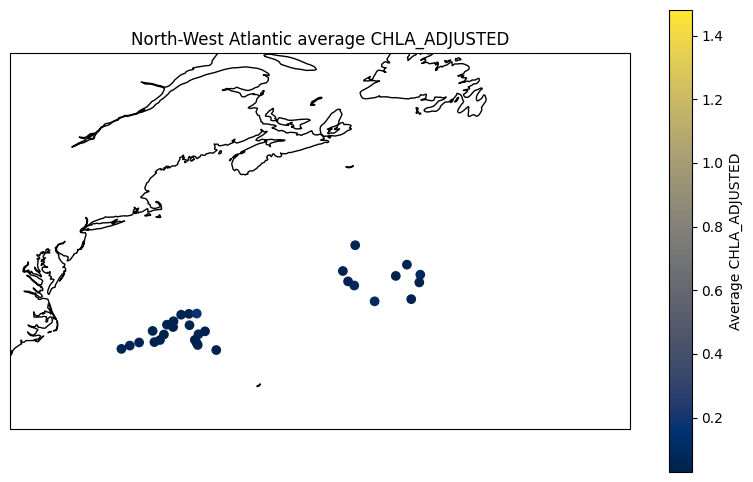

In [21]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Convert 'JULD' column to datetime type
df['JULD'] = pd.to_datetime(df['JULD'])

# Group by 'LATITUDE' and 'LONGITUDE', and aggregate by averaging over 'PRES_ADJUSTED', 'JULD', and 'CHLA_ADJUSTED'
grouped = df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'PRES_ADJUSTED': 'mean',  # Take the mean depth
    'JULD': lambda x: x.tolist(),  # Collect all time values into a list
    ref_var: 'mean'  # Take the mean intensity
}).reset_index()

# Plotting using Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot
cbar_min = df[ref_var].quantile(q=0.1)
cbar_max = df[ref_var].quantile(q=0.9)
plt.scatter(grouped['LONGITUDE'], grouped['LATITUDE'], c=grouped[ref_var], vmin=cbar_min, vmax=cbar_max, cmap='cividis', transform=ccrs.PlateCarree())
plt.colorbar(label='Average ' + ref_var)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('North-West Atlantic average ' + ref_var)
plt.grid(True)
plt.xlim([-78, -45])
plt.ylim([30, 50])
plt.show()

#### Exercise

Try and access some other metadata, for example:
* filtering by different time periods;
* mapping a different parameter;
* restraining the quality of the data further by imposing QC=1 only;
* performing reads/manipulations that you would need to perform your tasks.

If you encounter any issues, please [reach out](enrico.milanese@whoi.edu)!